********************************************************************************
					Coding Challenge for HUK Coburg
				Ratemaking: predicting pure insurance premium
********************************************************************************


*By Irina Simankova*

In [23]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from lib.starter import paths, formattingStyle
# set the path to the data
raw_data_path, data_path = paths()
# set the style of the plots and tables
formattingStyle()

# color RGB: 251, 211, 24, HEX: #FDD319
huk_yellow = '#FDD319'


In [24]:
num_var = [ 'Jahresbeitrag','Kundentreue',  'Alter', ]

bin_var =  ['Fahrerlaubnis', 'Vorversicherung', 'Vorschaden',
            'Geschlecht_M', 'Alter_Fzg_1',
            'Alter_Fzg_2', 'Alter_Fzg_3', 'Regional_Code_8', 'Regional_Code_15',
            'Regional_Code_28', 'Regional_Code_41', 'Regional_Code_46',
            'Regional_Code_Other', 'Vertriebskanal_26', 'Vertriebskanal_124',
            'Vertriebskanal_152', 'Vertriebskanal_156', 'Vertriebskanal_160',
            'Vertriebskanal_Other']

In [25]:
# read data
file = os.path.join(data_path, 'df.csv')
df_freq_sev = pd.read_csv(file, index_col=0)

# Data Preparation

In [26]:
X = df_freq_sev.drop([ 'Interesse', ], axis=1)
y = df_freq_sev['Interesse']

# check X variables
X.columns

Index(['Fahrerlaubnis', 'Vorversicherung', 'Vorschaden', 'Jahresbeitrag',
       'Kundentreue', 'Geschlecht_M', 'Alter', 'Alter_Fzg_1', 'Alter_Fzg_2',
       'Alter_Fzg_3', 'Regional_Code_8', 'Regional_Code_15',
       'Regional_Code_28', 'Regional_Code_41', 'Regional_Code_46',
       'Regional_Code_Other', 'Vertriebskanal_26', 'Vertriebskanal_124',
       'Vertriebskanal_152', 'Vertriebskanal_156', 'Vertriebskanal_160',
       'Vertriebskanal_Other'],
      dtype='object')

In [27]:
# split X, y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

Focus on recall (how many of actually positive are predicted as positice) 

In [28]:
# random forst with gridsearch
# define the model
model = RandomForestClassifier(random_state=42, n_estimators=200)

# define grid search
param_grid = {
    'max_depth': [5, 10, 20, ],
}

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2,
                           scoring='recall')

# fit the model
grid_search.fit(X_train, y_train)

# best parameters
print(grid_search.best_params_)

# best model
best_model = grid_search.best_estimator_

# predict
y_pred = best_model.predict(X_test)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'max_depth': 20}


Recall: 0.03265777591095243
Precision: 0.42955801104972374
F1: 0.060700692885722655
Accuracy: 0.8737241216446695


''

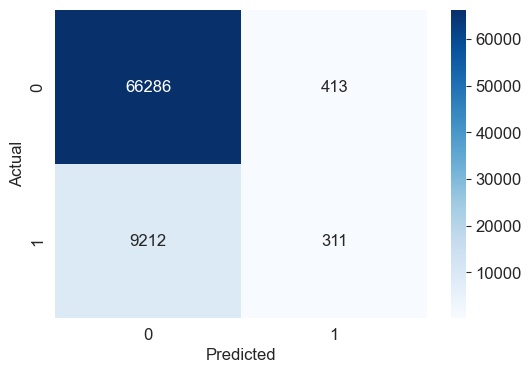

In [29]:
recall = recall_score(y_test, y_pred)
print('Recall:', recall)
precision = precision_score(y_test, y_pred)
print('Precision:', precision)
f1 = 2 * (precision * recall) / (precision + recall)
print('F1:', f1)
accuracy = best_model.score(X_test, y_test)
print('Accuracy:', accuracy)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
;

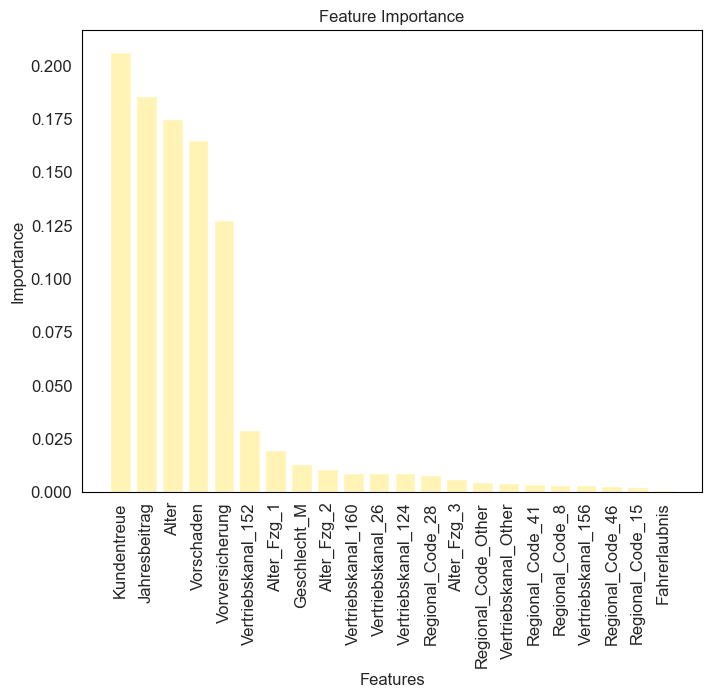

In [30]:
# feature importance
importances = best_model.feature_importances_

# sort importances
indices = np.argsort(importances)[::-1]

# plot
plt.figure(figsize=(8, 6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

- high accuracy just reflects the unbalancedness of the data

# Downsampling

In [31]:
# downsample 

from sklearn.utils import resample

# concatenate training data
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_interested = X[X.Interesse==0]
interested = X[X.Interesse==1]

# downsample majority
not_interested_downsampled = resample(not_interested,
                                      replace=False, # sample without replacement
                                      n_samples=len(interested), # match minority n
                                      random_state=42) # repro

# combine minority and downsampled majority

downsampled = pd.concat([not_interested_downsampled, interested])

# check counts
downsampled.Interesse.value_counts()

Interesse
0.00    37187
1.00    37187
Name: count, dtype: int64

In [32]:
# split X, y

X_train = downsampled.drop('Interesse', axis=1)
y_train = downsampled.Interesse


## Random Forest

In [33]:
# random forst with gridsearch
# define the model
model = RandomForestClassifier(random_state=42, n_estimators=500)

# define grid search
param_grid = {
    'max_depth': [5, 10,  30, 40],
    'min_samples_leaf': [1, 10, 100, ],
}

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2,
                           scoring='recall')

# fit the model1
grid_search.fit(X_train, y_train)
# best parameters
print(grid_search.best_params_)
# best model
best_model = grid_search.best_estimator_
# predict
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 10, 'min_samples_leaf': 1}


Recall: 0.9414050194266512
Precision: 0.28196257273156156
F1: 0.43395130451619146
Accuracy: 0.6931594552753798


''

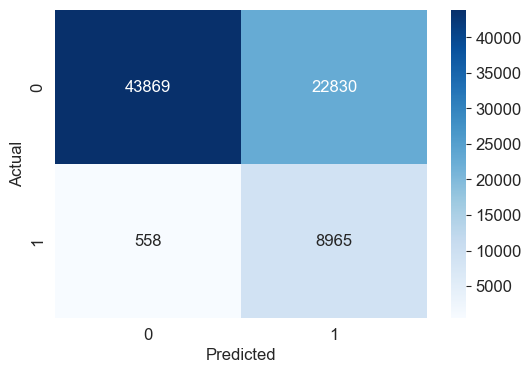

In [34]:
recall = recall_score(y_test, y_pred)
print('Recall:', recall)
precision = precision_score(y_test, y_pred)
print('Precision:', precision)
f1 = 2 * (precision * recall) / (precision + recall)
print('F1:', f1)
accuracy = best_model.score(X_test, y_test)
print('Accuracy:', accuracy)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
;

## XGBoost

In [36]:
# xgboost

# define the model
model = XGBClassifier(random_state=42, n_estimators=200)

# define grid search
param_grid = {
    'max_depth': [3, 5, 7, 10, 13],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],  
}

grid_search = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1,
                            verbose=2,
                            scoring='recall')

# fit the model
grid_search.fit(X_train, y_train)
# best parameters
print(grid_search.best_params_)
# best model
best_model = grid_search.best_estimator_
# predict
y_pred = best_model.predict(X_test)
    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500}


Recall: 0.9696524204557387
Precision: 0.26327193932827736
F1: 0.4141085723254928


Accuracy: 0.6571987090341371


Text(44.722222222222214, 0.5, 'Actual')

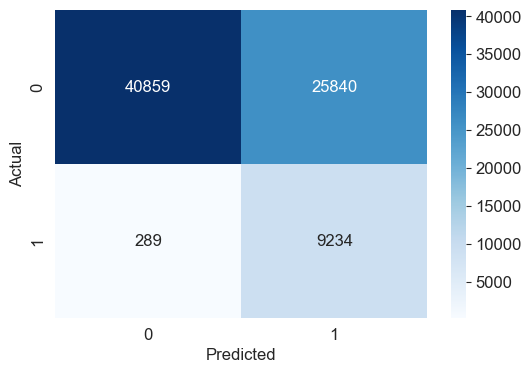

In [37]:
recall = recall_score(y_test, y_pred)
print('Recall:', recall)
precision = precision_score(y_test, y_pred)
print('Precision:', precision)
f1 = 2 * (precision * recall) / (precision + recall)
print('F1:', f1)
accuracy = best_model.score(X_test, y_test)
print('Accuracy:', accuracy)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')